# Photometry Homework Week 9
23160004 Tae-Hyoung Kim

In [1]:
from DELCgen_modified import *

▲▲▲ I modified the fucntion 'datalc.FIT_PSD' in 'DELCgen.py' to get fitted parameters ▲▲▲

In [2]:
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats as st
from scipy import interpolate
from astropy.modeling import models, fitting
import pandas as pd
import numpy as np
import readline
import os
import sys

In [3]:
def SPL(v, alpha1, b1):
    return 10**(np.log10(v)*alpha1 + np.log10(b1))

def CPL(v, alpha1, alpha2, b1):
    return 10**(alpha1*np.log10(v)**2 + alpha2*np.log10(v) + np.log10(b1))

def BPL(v, A, v_bend, a_high, c):
    p = BendingPL(v,A,v_bend,1.1,a_high,c)
    return p


def simLC(path_datafile, path_output, mode='original',paramsSPL=[1,-1],paramsBPL=[1,1,1,1],paramsCPL=[1,1,1],fit_original=False,create_arbitrary=True):

    # python2 version of simulating LC
    # in case Jeff's workaround for py3 doesn't work

    # mode = original, simplePL, brokenPL, curvedPL
    
    #------- Input parameters -------

    # File Route

    # org_time, org_flux = np.genfromtxt(path_datafile, usecols=(0,1), unpack=True)

    # Bending power law params
    A,v_bend,a_low,a_high,c = 0.03, 2.3e-4, 1.1, 2.2, 0.009

    # Probability density function params
    kappa,theta,lnmu,lnsig,weight = 5.67, 5.96, 2.14, 0.31,0.82
    # Simulation pa
    RedNoiseL,aliasTbin, RandomSeed, tbin = 100,1,6501,7

    #--------- Commands ---------------

    # load data lightcurve
    datalc = Load_Lightcurve(path_datafile,tbin)

    # create mixture distribution to fit to PDF
    mix_model = Mixture_Dist([st.gamma,st.lognorm],[3,3],[[[2],[0]],[[2],[0],]])


    # estimate underlying variance of data light curve

    if(mode=='original'):
        delc = datalc.Simulate_DE_Lightcurve()

    else:

        if(mode=='simplePL'):
            initials = [1,1]
            def model(v, alpha1, b1):
                return 10**(np.log10(v)*alpha1 + np.log10(b1))

        if(mode=='brokenPL'):
            initials = [1,1,1,1]
            def model(v,A,v_bend,a_high,c):
                p = BendingPL(v,A,v_bend,1.1,a_high,c)
                return p

        if(mode=='curvedPL'):
            initials = [1,1,1]
            def model(v, alpha1, alpha2, b1):
                return 10**(alpha1*np.log10(v)**2 + alpha2*np.log10(v) + np.log10(b1))

        Fitted_parameter_DELCgen = datalc.Fit_PSD(initial_params=initials,model=model)
        # datalc.Fit_PDF(initial_params=[kappa,theta,lnmu,lnsig,weight],model=mix_model )
        # datalc.STD_Estimate()
        # delc = Simulate_DE_Lightcurve(model,lightcurve=datalc)
        if fit_original == True:
            delc = datalc.Simulate_DE_Lightcurve()
        elif create_arbitrary == True:
            if(mode=='simplePL'):
                # print(datalc.pdfFit[s'x'][0])
                #delc = datalc.Simulate_DE_Lightcurve(model,(paramsSPL[0],paramsSPL[1]))
                print(paramsSPL)
                print(model)
                surrogate, PSDlast, shortLC, periodogram, fft = EmmanLC(datalc.time, RedNoiseL,aliasTbin,RandomSeed, tbin, PSDmodel=SPL, PSDparams=paramsSPL,
                                                PDFmodel=mix_model, PDFparams=[kappa,theta,lnmu,lnsig,weight])
                ## surrogate[0] = simulated time, surrogate[1] = simulated flux
                ## PSDLast[0] = simulated freq, PSDLast[1] = simulated power
                ax1 = plt.subplot(121)
                ax2 = plt.subplot(122)
                ax1.plot(surrogate[0],surrogate[1],label="Simulated LC")
                ax2.plot(np.log10(PSDlast[0]),np.log10(PSDlast[1]),label="Simulated PSD")
                plt.legend()
                plt.show()
                return PSDlast, Fitted_parameter_DELCgen

            if(mode=='brokenPL'):
                # print(datalc.pdfFit[s'x'][0])
                #delc = datalc.Simulate_DE_Lightcurve(model,(paramsSPL[0],paramsSPL[1]))
                print(paramsBPL)
                print(model)
                surrogate, PSDlast, shortLC, periodogram, fft = EmmanLC(datalc.time, RedNoiseL,aliasTbin,RandomSeed, tbin, PSDmodel=BPL, PSDparams=paramsBPL,
                                                PDFmodel=mix_model, PDFparams=[kappa,theta,lnmu,lnsig,weight])
                ## surrogate[0] = simulated time, surrogate[1] = simulated flux
                ## PSDLast[0] = simulated freq, PSDLast[1] = simulated power
                ax1 = plt.subplot(121)
                ax2 = plt.subplot(122)
                ax1.plot(surrogate[0],surrogate[1],label="Simulated LC")
                ax2.plot(np.log10(PSDlast[0]),np.log10(PSDlast[1]),label="Simulated PSD")
                plt.show()
                return PSDlast, Fitted_parameter_DELCgen
            
            if(mode=='curvedPL'):
                # print(datalc.pdfFit[s'x'][0])
                #delc = datalc.Simulate_DE_Lightcurve(model,(paramsSPL[0],paramsSPL[1]))
                print(paramsCPL)
                print(model)
                surrogate, PSDlast, shortLC, periodogram, fft = EmmanLC(datalc.time, RedNoiseL,aliasTbin,RandomSeed, tbin, PSDmodel=CPL, PSDparams=paramsCPL,
                                                PDFmodel=mix_model, PDFparams=[kappa,theta,lnmu,lnsig,weight])
                ## surrogate[0] = simulated time, surrogate[1] = simulated flux
                ## PSDLast[0] = simulated freq, PSDLast[1] = simulated power
                ax1 = plt.subplot(121)
                ax2 = plt.subplot(122)
                ax1.plot(surrogate[0],surrogate[1],label="Simulated LC")
                ax2.plot(np.log10(PSDlast[0]),np.log10(PSDlast[1]),label="Simulated PSD")
                plt.show()
                return PSDlast, Fitted_parameter_DELCgen

    
    # save the simulated light curve as a txt file
    # delc.Save_Lightcurve(path_output)

path_datafile = "./filtered.csv"
path_output   = "./test.lc"
#mode = "simplePL"

print(path_datafile)

./filtered.csv


In [4]:
def logSPL(v, alpha1, b1):
    return np.log10(v)*alpha1 + np.log10(b1)

def logCPL(v, alpha1, alpha2, b1):
    return alpha1*np.log10(v)**2 + alpha2*np.log10(v) + np.log10(b1)

# 1) Simple Power Law

Read 730 lines of data


/home/taehyoung/.local/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log10



### Fit successful: ###
Parameter 1: -1.37147191947
Parameter 2: 0.0120339971049
[1, 1]
<function model at 0x7ff3732a3bd0>


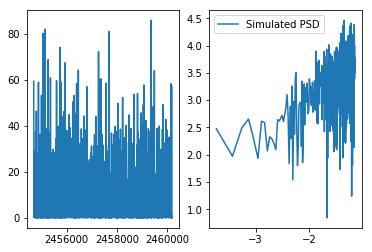

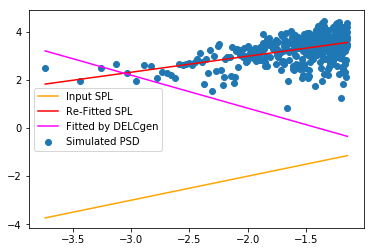

('Input Parameter =', 1, 1)
('Re-fitted Parameter=', 0.6680058764722429, 20947.22054280136)
('Fitted Parameter by DELCgen=', -1.3714719194724894, 0.012033997104931885)


In [5]:
PSDparams=[1,1]
PSD, DELCgen_result = simLC(path_datafile, path_output, mode='simplePL', paramsSPL = PSDparams)
logPSD = np.log10(PSD)

#Fitparams, cov = curve_fit(SPL, PSD[0], PSD[1], p0=PSDparams)
logFitparams, logcov = curve_fit(logSPL, PSD[0], logPSD[1], p0=PSDparams)

plt.scatter(logPSD[0], logPSD[1], label='Simulated PSD')
plt.plot(logPSD[0], np.log10(SPL(PSD[0], PSDparams[0], PSDparams[1])), label='Input SPL', color='orange')
#plt.plot(logPSD[0], np.log10(SPL(PSD[0], Fitparams[0], Fitparams[1])), label='Re-Fitted SPL', color='red')
plt.plot(logPSD[0], logSPL(PSD[0], logFitparams[0], logFitparams[1]), label='Re-Fitted SPL', color='red')
plt.plot(logPSD[0], logSPL(PSD[0], DELCgen_result[0], DELCgen_result[1]), label='Fitted by DELCgen', color='magenta')
plt.legend()
plt.show()

print('Input Parameter =', PSDparams[0], PSDparams[1])
#print('Re-fitted Parameter=', Fitparams[0], Fitparams[1])
print('Re-fitted Parameter=', logFitparams[0], logFitparams[1])
print('Fitted Parameter by DELCgen=', DELCgen_result[0], DELCgen_result[1])

# 2) Broken Power Law

Read 730 lines of data


DELCgen_modified.py:394: RuntimeWarning: invalid value encountered in log
  p = 2.0 * np.sum( np.log(psd[:-1]) + (periodogram[1][:-1]/psd[:-1]) )
DELCgen_modified.py:395: RuntimeWarning: invalid value encountered in log
  p_nq = np.log(np.pi * periodogram[1][-1]*psd[-1]) \
DELCgen_modified.py:237: RuntimeWarning: invalid value encountered in power
  denom = 1 + (v/v_bend)**(a_high-a_low)



### Fit successful: ###
Parameter 1: 0.0555046017076
Parameter 2: 0.0201609252413
Parameter 3: 5.12902156771
Parameter 4: 0.618422817653
[1, 1, 1, 1]
<function model at 0x7ff3b3f054d0>


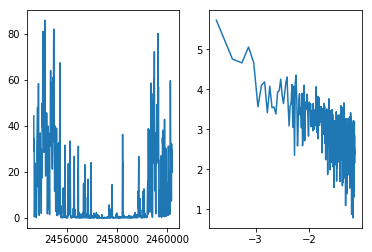

/home/taehyoung/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:791: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/taehyoung/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


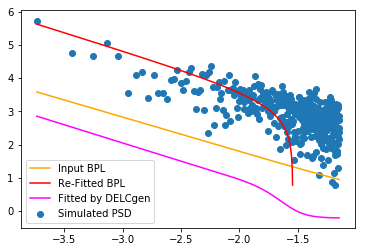

('Input Parameter =', 1, 1, 1, 1)
('Re-Fitted Parameter =', 32.69178705344877, 5727.059116912882, 79.37817020610896, -1631.3073742984807)
('Fitted Parameter by DELCgen=', 0.055504601707594955, 0.020160925241347494, 5.129021567711675, 0.618422817652746)


In [6]:
PSDparams=[1,1,1,1]

PSD, DELCgen_result = simLC(path_datafile, path_output, mode='brokenPL', paramsBPL = PSDparams)

Fitparams, cov = curve_fit(BPL, PSD[0], PSD[1], p0=PSDparams, maxfev = 10000)

plt.scatter(np.log10(PSD[0]), np.log10(PSD[1]), label='Simulated PSD')
plt.plot(np.log10(PSD[0]), np.log10(BPL(PSD[0], PSDparams[0], PSDparams[1], PSDparams[2], PSDparams[3])), label='Input BPL', color='orange')
plt.plot(np.log10(PSD[0]), np.log10(BPL(PSD[0], Fitparams[0], Fitparams[1], Fitparams[2], Fitparams[3])), label='Re-Fitted BPL', color='red')
plt.plot(np.log10(PSD[0]), np.log10(BPL(PSD[0], DELCgen_result[0], DELCgen_result[1], DELCgen_result[2], DELCgen_result[3])), label='Fitted by DELCgen', color='magenta')
plt.legend()
plt.show()
print('Input Parameter =', PSDparams[0], PSDparams[1], PSDparams[2], PSDparams[3])
print('Re-Fitted Parameter =', Fitparams[0], Fitparams[1], Fitparams[2], Fitparams[3])
print('Fitted Parameter by DELCgen=', DELCgen_result[0], DELCgen_result[1], DELCgen_result[2], DELCgen_result[3])

# 3) Curved Power Law

Read 730 lines of data


/home/taehyoung/.local/lib/python2.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in log10
/home/taehyoung/.local/lib/python2.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in power



### Fit successful: ###
Parameter 1: -0.128784453839
Parameter 2: -1.85002846329
Parameter 3: 0.00465155160567
[1, 2, 4]
<function model at 0x7ff35d119550>


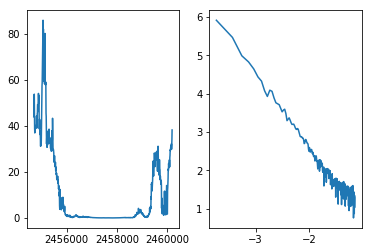

/home/taehyoung/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


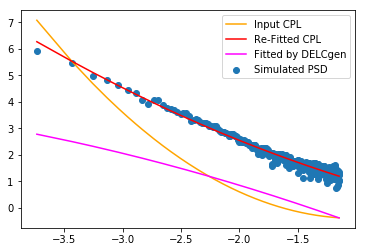

('Input Parameter =', 1, 2, 4)
('Re-Fitted Parameter =', 0.21852380645747668, -0.8949511625723624, 0.7615749985349788)
('Fitted Parameter by DELCgen=', -0.1287844538390288, -1.850028463288821, 0.0046515516056650115)


In [7]:
PSDparams=[1,2,4]

PSD, DELCgen_result= simLC(path_datafile, path_output, mode='curvedPL', paramsCPL = PSDparams)
logPSD=np.log10(PSD)

#Fitparams, cov = curve_fit(CPL, PSD[0], PSD[1], p0=PSDparams, maxfev = 10000)
logFitparams, logcov = curve_fit(logCPL, PSD[0], logPSD[1], p0=PSDparams, maxfev = 10000)


plt.scatter(np.log10(PSD[0]), np.log10(PSD[1]), label='Simulated PSD')
#plt.plot(np.log10(PSD[0]), np.log10(CPL(PSD[0], Fitparams[0], Fitparams[1], Fitparams[2])), label='Re-Fitted CPL', color='red')
plt.plot(logPSD[0], np.log10(CPL(PSD[0], PSDparams[0], PSDparams[1], PSDparams[2])), label='Input CPL', color='orange')
plt.plot(logPSD[0], logCPL(PSD[0], logFitparams[0], logFitparams[1], logFitparams[2]), label='Re-Fitted CPL', color='red')
plt.plot(logPSD[0], logCPL(PSD[0], DELCgen_result[0], DELCgen_result[1], DELCgen_result[2]), label='Fitted by DELCgen', color='magenta')
plt.legend()
plt.show()
print('Input Parameter =', PSDparams[0], PSDparams[1], PSDparams[2])
#print('Out=', Fitparams[0], Fitparams[1], Fitparams[2])
print('Re-Fitted Parameter =', logFitparams[0], logFitparams[1], logFitparams[2])
print('Fitted Parameter by DELCgen=', DELCgen_result[0], DELCgen_result[1], DELCgen_result[2])

# Graveyard

In [8]:
'''
PSDparams=[1,1,1]

PSD = simLC(path_datafile, path_output, mode='curvedPL', paramsCPL = PSDparams)

Fitparams, cov = curve_fit(CPL, PSD[0], PSD[1], p0=PSDparams, maxfev = 10000)

plt.scatter(np.log10(PSD[0]), np.log10(PSD[1]), label='Simulated PSD')
plt.plot(np.log10(PSD[0]), np.log10(CPL(PSD[0], Fitparams[0], Fitparams[1], Fitparams[2])), label='Re-Fitted CPL', color='red')
plt.plot(np.log10(PSD[0]), np.log10(CPL(PSD[0], PSDparams[0], PSDparams[1], PSDparams[2])), label='Input CPL', color='orange')
plt.legend()
plt.show()
print('In =', PSDparams[0], PSDparams[1], PSDparams[2])
print('Out=', Fitparams[0], Fitparams[1], Fitparams[2])
'''

"\nPSDparams=[1,1,1]\n\nPSD = simLC(path_datafile, path_output, mode='curvedPL', paramsCPL = PSDparams)\n\nFitparams, cov = curve_fit(CPL, PSD[0], PSD[1], p0=PSDparams, maxfev = 10000)\n\nplt.scatter(np.log10(PSD[0]), np.log10(PSD[1]), label='Simulated PSD')\nplt.plot(np.log10(PSD[0]), np.log10(CPL(PSD[0], Fitparams[0], Fitparams[1], Fitparams[2])), label='Re-Fitted CPL', color='red')\nplt.plot(np.log10(PSD[0]), np.log10(CPL(PSD[0], PSDparams[0], PSDparams[1], PSDparams[2])), label='Input CPL', color='orange')\nplt.legend()\nplt.show()\nprint('In =', PSDparams[0], PSDparams[1], PSDparams[2])\nprint('Out=', Fitparams[0], Fitparams[1], Fitparams[2])\n"

In [9]:
'''
PSDparams=[3,20]

PSD = simLC(path_datafile, path_output, mode='simplePL', paramsSPL = PSDparams)

Fitparams, cov = curve_fit(SPL, PSD[0], PSD[1])

plt.scatter(np.log10(PSD[0]), np.log10(PSD[1]), label='Simulated PSD')
plt.plot(np.log10(PSD[0]), np.log10(SPL(PSD[0], Fitparams[0], Fitparams[1])), label='Re-Fitted SPL', color='red')
plt.plot(np.log10(PSD[0]), np.log10(SPL(PSD[0], PSDparams[0], PSDparams[1])), label='Input SPL', color='orange')
plt.legend()
plt.show()
print('In =', PSDparams[0], PSDparams[1])
print('Out=', Fitparams[0], Fitparams[1])
'''

"\nPSDparams=[3,20]\n\nPSD = simLC(path_datafile, path_output, mode='simplePL', paramsSPL = PSDparams)\n\nFitparams, cov = curve_fit(SPL, PSD[0], PSD[1])\n\nplt.scatter(np.log10(PSD[0]), np.log10(PSD[1]), label='Simulated PSD')\nplt.plot(np.log10(PSD[0]), np.log10(SPL(PSD[0], Fitparams[0], Fitparams[1])), label='Re-Fitted SPL', color='red')\nplt.plot(np.log10(PSD[0]), np.log10(SPL(PSD[0], PSDparams[0], PSDparams[1])), label='Input SPL', color='orange')\nplt.legend()\nplt.show()\nprint('In =', PSDparams[0], PSDparams[1])\nprint('Out=', Fitparams[0], Fitparams[1])\n"